# RFM Analysis

In [2]:
import math
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy.stats import norm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

### Dataset

This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
	
https://archive.ics.uci.edu/ml/datasets/online+retail

**Attribute Information**:

    InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
    StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
    Description: Product (item) name. Nominal.
    Quantity: The quantities of each product (item) per transaction. Numeric.
    InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
    UnitPrice: Unit price. Numeric, Product price per unit in sterling.
    CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
    Country: Country name. Nominal, the name of the country where each customer resides. 

In [3]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

In [5]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [6]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [7]:
# get the missing data
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

### Data Cleanup

In [ ]:
# delete the missing data
df.dropna(inplace=True)

In [ ]:
#Remove spaces  
df['Description'] = df['Description'].str.strip()

#drop the rows that don’t have invoice numbers
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)

#remove the credit transactions (those with invoice numbers containing C).
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]

## EDA

In [8]:
#Number of customers
df.CustomerID.unique().shape

(4373,)

In [9]:
#Number of stockcodes
df.StockCode.unique().shape

(4070,)

In [10]:
#transcations by country
df.groupby(['Country'])['InvoiceNo'].count().sort_values(ascending=False) 

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [11]:
(df.CustomerID.value_counts()/sum(df.CustomerID.value_counts())*100).head(n=13).cumsum()

nan        24.926694
17841.0    26.399820
14911.0    27.489117
14096.0    28.435402
12748.0    29.292003
14606.0    29.805373
15311.0    30.265045
14646.0    30.649795
13089.0    30.992473
13263.0    31.301934
14298.0    31.604568
15039.0    31.882844
14156.0    32.144880
Name: CustomerID, dtype: float64

## RFM Analysis
Calculation of RFM metrics (recency, frequency, and monetary)
    
    recency = date of analysis - purchase date of the relevant customer
    frequency = customer's total number of purchases
    monetary = total monetary value as a result of the customer's total purchases
    
We will assume the date of analysis was 2 days after the max(date) in the dataset

In [12]:
# TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.sort_values(by='TotalPrice', ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,nan,United Kingdom,13541.33
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,nan,United Kingdom,11062.06


In [13]:
# get the total price paid per each invoice
df.groupby('InvoiceNo').agg({'TotalPrice': 'sum'}).head().sort_values(by='TotalPrice', ascending=False)

,TotalPrice
InvoiceNo,
536367,278.73
536365,139.12
536368,70.05
536366,22.20
536369,17.85


In [18]:
# get the last invoice date in the dataset
max_date = df['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
# adding a day to the calculated max date as date of analysis
snapshot = max_date + dt.timedelta(days = 1)
snapshot

Timestamp('2011-12-10 12:50:00')

In [19]:
# group the customer id's to see every single customer's activity on r, f , m
customer_group = df.groupby("CustomerID") 
customer_group.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08
10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047.0,United Kingdom,12.60
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,90.00
...,...,...,...,...,...,...,...,...,...
538065,581385,21479,WHITE SKULL HOT WATER BOTTLE,72,2011-12-08 13:11:00,3.75,13298.0,United Kingdom,270.00
538812,581416,22466,FAIRY TALE COTTAGE NIGHT LIGHT,1,2011-12-08 14:58:00,1.95,14569.0,United Kingdom,1.95
538813,581416,21731,RED TOADSTOOL LED NIGHT LIGHT,1,2011-12-08 14:58:00,1.65,14569.0,United Kingdom,1.65
541768,581578,POST,POSTAGE,3,2011-12-09 12:16:00,18.00,12713.0,Germany,54.00


In [20]:
# the last day of grouped customer's transaction is captured with .max()
recency = (snapshot - customer_group["InvoiceDate"].max()) 

# the first day of grouped customer's transaction is captured with .min()
tenure = snapshot - customer_group["InvoiceDate"].min() 

# how many times the customer made transactions?
frequency = customer_group["InvoiceNo"].nunique() 

#how much total money has this customer spent
monetary = customer_group["TotalPrice"].sum()

In [21]:
# Create RFM table
# Groupby customer ID and aggregate on r, f, m,and t values

rfm = pd.DataFrame() 
rfm["Recency"] = recency.dt.days 
rfm["Frequency"] = frequency
rfm["Monetary"] = monetary
rfm["Tenure"] = tenure.dt.days 
rfm.head()

,Recency,Frequency,Monetary,Tenure
CustomerID,,,,
12346.0,326,2,0.00,326
12347.0,2,7,4310.00,367
12348.0,75,4,1797.24,358
12349.0,19,1,1757.55,19
12350.0,310,1,334.40,310


In [22]:
#recency
rfm.Recency.describe()

count    4373.000000
mean       92.026298
std       100.763317
min         1.000000
25%        17.000000
50%        50.000000
75%       143.000000
max       374.000000
Name: Recency, dtype: float64

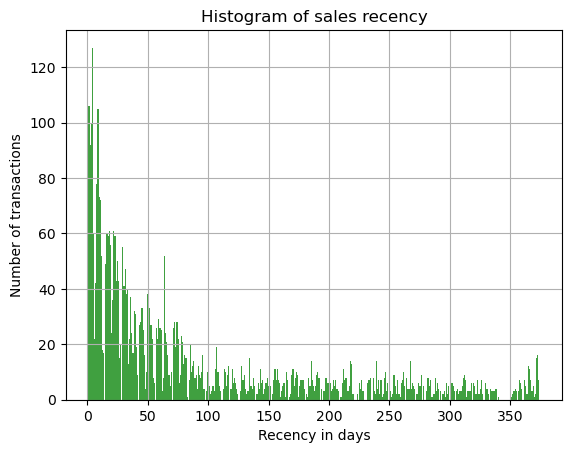

In [23]:
#Recency plot
x = rfm.Recency
mu = np.mean(rfm.Recency)
sigma = math.sqrt(np.var(rfm.Recency))
n, bins, patches = plt.hist(x, 400, facecolor='green', alpha=0.75)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'Histogram of sales recency')
plt.grid(True)

In [24]:
#scale all RFMT values in the range 1-5
min_max_scaler = MinMaxScaler((1,5))
scaled = min_max_scaler.fit_transform(rfm[["Recency","Frequency","Monetary","Tenure"]])
rfm = pd.DataFrame(scaled, columns=rfm.columns)
rfm.head()

,Recency,Frequency,Monetary,Tenure
0,4.485255,1.001078,1.011812,4.485255
1,1.010724,1.006471,1.023685,4.924933
2,1.793566,1.003235,1.016763,4.828418
3,1.193029,1.000000,1.016654,1.193029
4,4.313673,1.000000,1.012733,4.313673


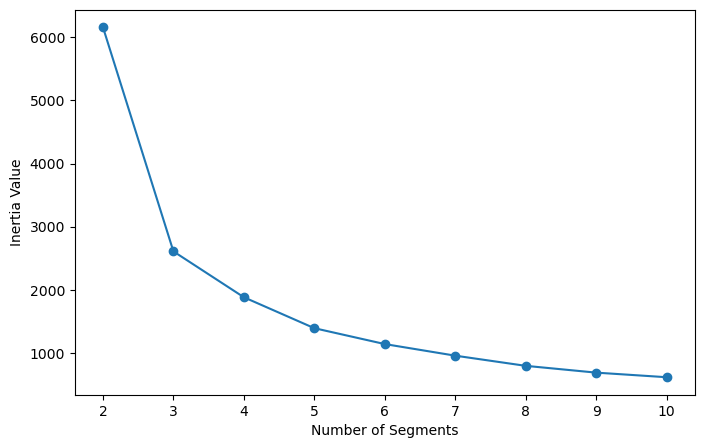

In [25]:
X = rfm.values 
n_cluster = range(2, 11, 1)
cost = []

for i in n_cluster:
    model = KMeans(n_clusters=i, random_state=13)
    model.fit(X)
    cost.append(model.inertia_)
    
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1,1,1)
ax.plot(n_cluster, cost, marker="o")
ax.set_xlabel("Number of Segments")
ax.set_ylabel("Inertia Value")
plt.show()

In [26]:
#k=3 probably gets better clusters, however the business would like to see 5 groups
n_cluster = 5

model = KMeans(n_clusters=n_cluster, random_state=2023)
y = model.fit_predict(rfm[["Recency","Frequency","Monetary","Tenure"]])

rfm["Segment"] = y
rfm.head() 

,Recency,Frequency,Monetary,Tenure,Segment
0,4.485255,1.001078,1.011812,4.485255,2
1,1.010724,1.006471,1.023685,4.924933,4
2,1.793566,1.003235,1.016763,4.828418,4
3,1.193029,1.000000,1.016654,1.193029,0
4,4.313673,1.000000,1.012733,4.313673,2


In [27]:
#lets take a look at each segment in terms of RFMT
rfm.groupby("Segment").mean()

,Recency,Frequency,Monetary,Tenure
Segment,,,,
0,1.416428,1.001174,1.013732,1.657706
1,2.891674,1.000956,1.013206,3.201524
2,4.111092,1.000959,1.013103,4.447566
3,1.386373,1.004606,1.016342,3.448520
4,1.363429,1.014147,1.027882,4.691506


In [28]:
humanization = {3:"Diamond", 1:"Platinum", 2:"Gold" , 4:"Silver", 0:"Bronze"}
rfm["Segment"].replace(humanization,inplace=True)
rfm.head()

,Recency,Frequency,Monetary,Tenure,Segment
0,4.485255,1.001078,1.011812,4.485255,Gold
1,1.010724,1.006471,1.023685,4.924933,Silver
2,1.793566,1.003235,1.016763,4.828418,Silver
3,1.193029,1.000000,1.016654,1.193029,Bronze
4,4.313673,1.000000,1.012733,4.313673,Gold


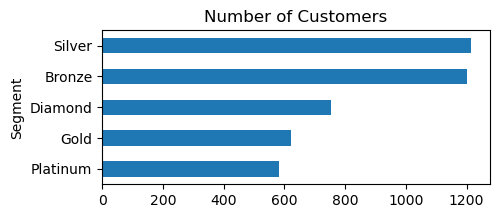

In [29]:
#group by topic and plot rows in the descending order
rfm.groupby('Segment').size().sort_values(ascending=True)\
    .plot(title="Number of Customers", kind='barh',figsize=(5,2))
plt.show()

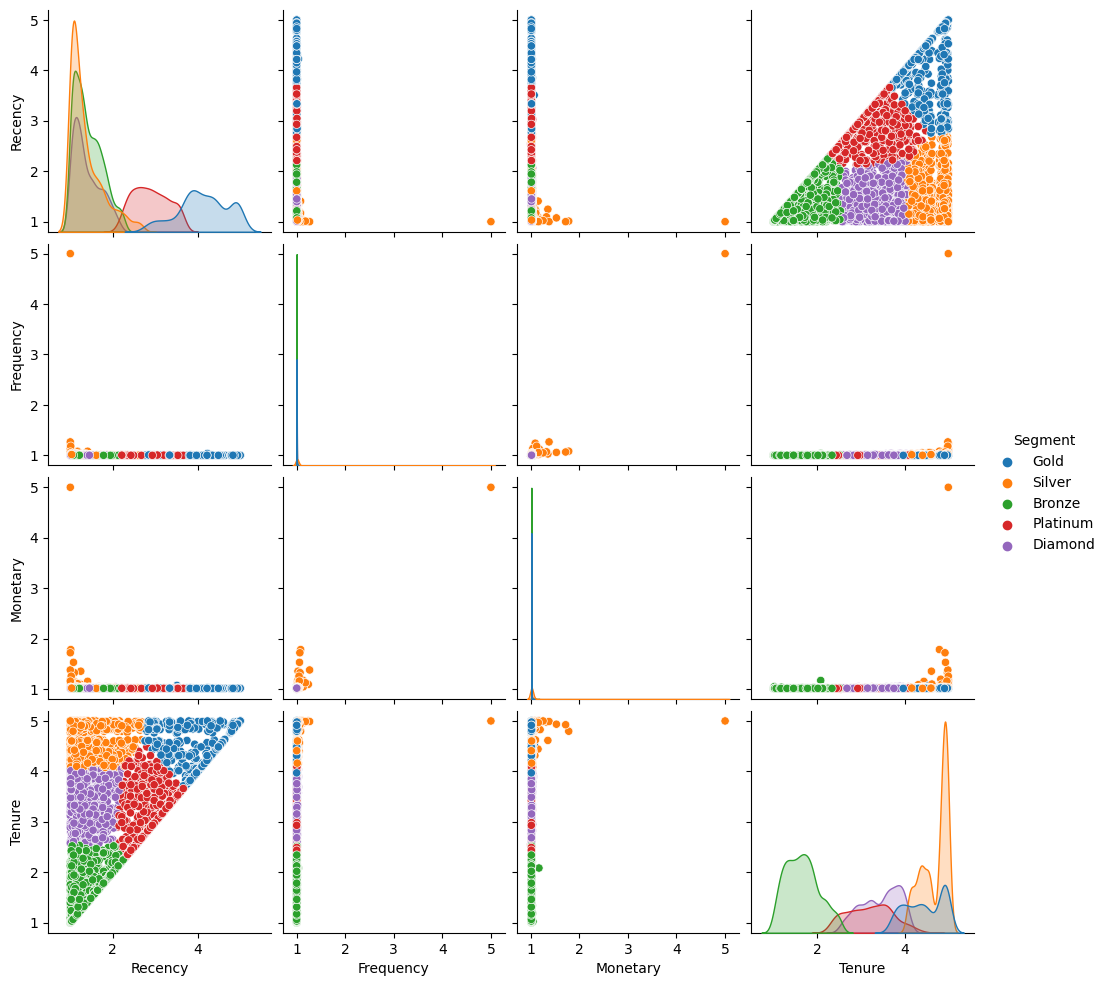

In [30]:
sns.pairplot(rfm, hue="Segment")
plt.show()

###  RFM Score (Clustering Alternative)
Score = (Recency score x Recency weight) + (Frequency score x Frequency weight) + (Monetary score x Monetary weight).

In [31]:
rfm["Score"] = 0.6*rfm['Recency'] + 0.2*rfm['Frequency'] + 0.2*rfm['Monetary']
rfm.head(2)

,Recency,Frequency,Monetary,Tenure,Segment,Score
0,4.485255,1.001078,1.011812,4.485255,Gold,3.093731
1,1.010724,1.006471,1.023685,4.924933,Silver,1.012466


In [32]:
std_scaler = StandardScaler()
std_score = std_scaler.fit_transform(rfm[["Score"]])
rfm['Std_Score'] = std_score
rfm.head(2)

,Recency,Frequency,Monetary,Tenure,Segment,Score,Std_Score
0,4.485255,1.001078,1.011812,4.485255,Gold,3.093731,2.322569
1,1.010724,1.006471,1.023685,4.924933,Silver,1.012466,-0.892760


In [33]:
rfm.describe()

,Recency,Frequency,Monetary,Tenure,Score,Std_Score
count,4373.000000,4373.000000,4373.000000,4373.000000,4373.000000,4.373000e+03
mean,1.976153,1.005309,1.017953,3.410863,1.590344,1.878214e-16
std,1.080572,0.061255,0.064345,1.269921,0.647369,1.000114e+00
min,1.000000,1.000000,1.000000,1.000000,1.002488,-9.081748e-01
25%,1.171582,1.000000,1.012620,2.222520,1.106732,-7.471282e-01
50%,1.525469,1.002157,1.013598,3.702413,1.318405,-4.201165e-01
75%,2.522788,1.004314,1.016253,4.549598,1.916658,5.041188e-01
max,5.000000,5.000000,5.000000,5.000000,3.402632,2.799788e+00
